In [1]:
import copy
import random
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt

In [2]:
# Gene activity visualization
def plot_gene_dynamics(df, title="Cell process Dynamics", genes=None):
    """
    Visualizes the dynamics of gene expression and cell energy, 
    scaling the energy so that its maximum is 1/4 of the maximum gene expression value.

    Arguments:
    - df: DataFrame containing simulation results
    - title: plot title
    - genes: dictionary with gene names as keys and line colors as values
             Example: {"ENGSENS": "blue", "HARVEST": "green"}
    """
    if genes is None:
        genes = {"ENGSENS": "blue", "FOODSENS": "red", "HARVEST": "green", "DIVISION": "purple"}

    # 1) Find the maximum gene expression value
    max_expr = 0.0
    for g in genes:
        if g in df.columns:
            max_expr = max(max_expr, df[g].max())

    if max_expr == 0:
        scale = 1.0
    else:
        # 2) Find the maximum energy and compute the scale such that
        # max_energy * scale = max_expr / 4
        max_energy = df["Energy"].max()
        scale = (max_expr / 4) / max_energy if max_energy != 0 else 1.0

    # 3) Create the figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # 4) Scaled energy plot
    ax.fill_between(
        df["Tick"],
        df["Energy"] * scale,
        color="orange", alpha=0.2,
        label=f"Energy (scaled ×{scale:.2f})"
    )

    # 5) Gene expression lines
    for gene, color in genes.items():
        if gene in df.columns:
            ax.plot(df["Tick"], df[gene], label=gene, color=color, linewidth=2)

    # 6) Additional baseline lines
    # ax.axhline(max_expr / 4, color='gray', linestyle=':', linewidth=0.5,
    #            label="Max energy on ¼ of max gene expr")
    ax.axhline(0, color='black', linestyle='--', linewidth=0.7)

    ax.set_title(title)
    ax.set_xlabel("Tick")
    ax.set_ylabel("Level (normalized)")
    ax.legend(loc="upper left")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
# Genes, protected from mutagenesis
EXCLUDED_FROM_MUTAGENESIS = {"MUTGUARD"}

# === Helper functions ===

def cond_all(conds, vars_):
    return all(eval(c, {}, vars_) for c in conds)

def cond_any(conds, vars_):
    return any(eval(c, {}, vars_) for c in conds)

def grow_and_cap(expr, promoter, enhancer):
    if promoter == 'wk':
        new = expr + 1
    elif promoter == 'av':
        new = expr * 2
    elif promoter == 'st':
        new = expr * 4
    else:
        new = expr
    cap = {'wk': 4, 'av': 16, 'st': 64}.get(enhancer, 64)
    return min(new, cap)

def gene_attempts(expr=12):  # Number of attempts a protein has to perform its function.
    return 3 + int(expr // 12)
    
# def toxin_effect(sigma, base_effect=0.4, k=0.01):
#     return (2 * base_effect) / (1 + np.exp(-k * sigma))
def toxin_effect(sigma, base_effect=0.4, k=0.01):
    return (base_effect * np.exp(sigma))

def detect_effect(sigma, detect_effect=0.05, k=1):
    return (k * np.exp(sigma)) / (64 * detect_effect)

# === State initialization ===

def initialize_state(receptors, metabolism, kinases, cell_cycle, division, initial_energy, initial_food):
    all_genes = {**receptors, **metabolism, **kinases, **cell_cycle, **division}
    gene_list = list(all_genes.keys())
    return {
        "all_genes": all_genes,
        "gene_list": gene_list,
        "gene_expr": {g: 1 for g in gene_list},
        "gene_status": {g: "inactive" for g in gene_list},
        "gene_prot": {g: 0.0 for g in gene_list},
        "deact_delay": {g: False for g in gene_list},
        "energy": initial_energy,
        "food": initial_food,
        "toxin_detected": False,
        "expressed_flag": {g: False for g in gene_list},
        "mut_detected": False,
        "genes": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
        "reference_genome": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
    }

# === Toxin logic ===

def evaluate_toxins(toxins: dict, toxin_k: float):
    """
    Computes the effects of toxins.
    Returns: tox_penalties, tox_levels
    """
    tox_penalties = {}
    tox_levels = {}
    for name, (sigma, (param, base_eff)) in toxins.items():
        tox_levels[name] = sigma
        eff = toxin_effect(sigma, base_eff, toxin_k)
        if param == "common":
            for p in ["energy", "TPM"]:
                tox_penalties[p] = tox_penalties.get(p, 0.0) + eff
        else:
            tox_penalties[param] = tox_penalties.get(param, 0.0) + eff
    return tox_penalties, tox_levels

# === Logic of cellular products (including toxic ones) ===

def generate_cellular_products(
    prev_expr: dict,
    prev_status: dict,
    cellular_products: dict,
    env_products: dict,
    toxins: dict,
    energy_spent: float,
    TPM_sum: float
) -> Tuple[dict, dict]:
    """
    Step 2. Generate cellular products and increase sigma of toxins.
    Returns updated (env_products, toxins).
    """
    for name, (mode, coeff) in cellular_products.items():
        if mode == "energy":
            delta = coeff * energy_spent
        elif mode == "TPMsum":
            delta = coeff * TPM_sum
        elif mode in prev_status:
            # ген-специфичный продукт
            delta = coeff * prev_expr[mode] if prev_status[mode] == "active" else 0.0
        else:
            raise ValueError(f"Unknown production mode '{mode}' for product '{name}'")

        env_products[name] = env_products.get(name, -3.0) + delta

        if name in toxins:
            sigma, (p, b) = toxins[name]
            toxins[name] = (sigma + delta, (p, b))

    return env_products, toxins

# === Gene logic ===

def process_gene_functions(
    all_genes: dict,
    gene_list: list,
    prev_status: dict,
    prev_expr: dict,
    new_expr: dict,
    gene_prot: dict,
    energy: float,
    toxins: dict,
    state: dict
) -> Tuple[bool, float, float, dict]:
    division_happened = False
    division_cost = 0.0

    for g, (thr, mode, _, _, _, _, func) in all_genes.items():
        if not func or prev_status[g] != "active" or prev_expr[g] < thr:
            continue

        ftype, val = func
        eff = new_expr[g] if mode == "quan" else thr

        if ftype == "energy":
            energy += eff * val

        elif ftype == "process":
            to_proc, rem = eff, 0.0
            for tgt in gene_list:
                if tgt == g or gene_prot[tgt] <= 0 or to_proc <= 0:
                    continue
                cut = min(gene_prot[tgt], to_proc)
                gene_prot[tgt] -= cut
                to_proc     -= cut
                rem         += cut
            energy += rem * val

        elif ftype == "RNAdigest":
            to_dig, dig = eff, 0.0
            for tgt in gene_list:
                if to_dig <= 0:
                    break
                av = new_expr[tgt] - 1
                if av <= 0:
                    continue
                cut = min(av, to_dig)
                new_expr[tgt] -= cut
                to_dig       -= cut
                dig          += cut
            energy += dig * val

        elif ftype == "div":
            division_cost    += val
            division_happened = True

        elif ftype == "detox":
            detox_power = (eff / 64) * val
            for name in toxins:
                sigma, (param, base_eff) = toxins[name]
                new_sigma = max(-3, sigma - detox_power)
                toxins[name] = (new_sigma, (param, base_eff))

        # --- mutation sensor ---
        elif ftype == "mutsens":
            sens_chance = val
            expr = state["gene_expr"].get(g, 0)
            attempts = gene_attempts(expr)

            ref  = state["reference_genome"]
            curr = state["genes"]

            found = False
            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene] and random.random() < sens_chance:
                        found = True
                        break
                if found:
                    break

            if found:
                state["mut_detected"] = True

        # --- mutation repair ---
        elif ftype == "mutrep" and state.get("mut_detected", False):

            rep_chance = val
            expr = state["gene_expr"].get(g, 0)
            attempts = gene_attempts(expr)

            ref  = state["reference_genome"]  # “normal” genome prior to the last division
            curr = state["genes"]             # “physical” copy currently affected by mutations

            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene]:  # found a gene where current != reference
                        if random.random() < rep_chance:
                            curr[gene] = ref[gene]
                        elif random.random() < rep_chance:
                            curr[gene] = mutate_gene(curr[gene])
            # print(f"[MUTREP] gene={g}, attempts={attempts}, ref!=curr for genes:",  # Logging repairation
            #     [x for x in ref if curr[x]!=ref[x]])                                # Logging repairation

    return division_happened, division_cost, energy, toxins

# === Mutagenesis logic ===

def mutate_genes(all_genes: dict, mutation_chance: float) -> dict:
    """
    Randomly mutates some genes,
    but skips those listed in EXCLUDED_FROM_MUTAGENESIS.
    """
    new_genes = copy.deepcopy(all_genes)
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    
    for g, (thr, mode, prom, enh, on_cond, off_cond, func) in new_genes.items():
        # skip if this gene is in the exclusion list
        if g in EXCLUDED_FROM_MUTAGENESIS:
            continue

        if random.random() < mutation_chance:
            mutation_type = random.choice(['threshold', 'promoter', 'enhancer'])

            if mutation_type == 'threshold':
                delta = random.choice([-1, 1])
                thr = max(1, thr + delta)

            elif mutation_type == 'promoter':
                prom = random.choice(promoters)

            elif mutation_type == 'enhancer':
                enh = random.choice(enhancers)

            new_genes[g] = (thr, mode, prom, enh, on_cond, off_cond, func)

    return new_genes

def mutate_gene(gene_record):
    thr, mode, prom, enh, on_cond, off_cond, func = gene_record
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    mutation_type = random.choice(['threshold','promoter','enhancer'])
    if mutation_type == 'threshold':
        thr = max(1, thr + random.choice([-1,1]))
    elif mutation_type == 'promoter':
        prom = random.choice(promoters)
    else:
        enh = random.choice(enhancers)
    return (thr, mode, prom, enh, on_cond, off_cond, func)

# === One simulation step ===

def simulate_tick(state, toxins, energy_cost, toxin_k, cellular_products, env_products):
    # 1. Unpack state
    all_genes      = state["all_genes"]
    gene_list      = state["gene_list"]
    prev_expr      = state["gene_expr"]
    prev_status    = state["gene_status"]
    prev_prot      = state["gene_prot"]
    deact_delay    = state["deact_delay"]
    energy         = state["energy"]
    food           = state["food"]
    prev_expressed = state["expressed_flag"]

    # 2. TPM costs
    TPM_sum = sum(prev_expr.values())
    tpm_cost = TPM_sum * energy_cost
    energy_spent = tpm_cost

    # 3. Products and toxins
    env_products, toxins = generate_cellular_products(
        prev_expr, prev_status,
        cellular_products, env_products,
        toxins,
        energy_spent, TPM_sum
    )
    tox_penalties, tox_levels = evaluate_toxins(toxins, toxin_k)
    total_toxins = max(tox_levels.values())

    # 4. Toxin detection
    toxin_detected = False
    for g, (_, _, _, _, _, _, func) in all_genes.items():
        if func and func[0] == "toxsens" and prev_status[g] == "active":
            sens_prob = detect_effect(total_toxins, detect_effect=func[1], k=prev_expr[g])
            if sens_prob > 1:
                toxin_detected = True
                break

    # 5. Toxicity penalty
    if "energy" in tox_penalties:
        energy -= tox_penalties["energy"]

    # 6. Local variables
    local = {
        "Energy": energy,
        "Food": food,
        "Toxin": total_toxins,
        "Toxin_detected": toxin_detected
    }
    local.update(prev_status)

    # 7. Flags
    new_expressed = {}
    for g, (_, mode, prom, enh, on_cond, off_cond, _) in all_genes.items():
        stop_cond  = cond_any(off_cond,  local)
        start_cond = cond_all(on_cond, local) and not stop_cond
        new_expressed[g] = (prev_expressed[g] and not stop_cond) or start_cond

    had_off = {g: cond_any(all_genes[g][5], local) for g in gene_list}

    # 8. Expression
    new_expr = {}
    for g, (thr, _, prom, enh, _, _, _) in all_genes.items():
        if new_expressed[g]:
            val  = grow_and_cap(prev_expr[g], prom, enh)
            tpen = 1 - min(tox_penalties.get("TPM", 0.0), 1)
            new_expr[g] = max(1, val * tpen)
        else:
            new_expr[g] = 1

    # 9. Status
    new_status = {}
    for g, (thr, _, _, _, on_cond, _, _) in all_genes.items():
        if deact_delay[g]:
            new_status[g] = "inactive"
            deact_delay[g] = False
        elif prev_status[g] == "active":
            if had_off[g]:
                new_status[g] = "active"
                deact_delay[g] = True
            else:
                new_status[g] = "active"
        else:
            new_status[g] = (
                "active"
                if (not had_off[g] and cond_all(on_cond, local) and new_expr[g] >= thr)
                else "inactive"
            )

    # 11. Protein
    gene_prot = {g: prev_prot[g] + prev_expr[g] for g in gene_list}

    # 12. Execute gene functions (including mutsens and mutrep)
    division_happened, division_cost, energy, toxins = process_gene_functions(
        all_genes, gene_list, prev_status,
        prev_expr, new_expr, gene_prot,
        energy, toxins,
        state
    )

    # 13. Division reset
    if division_happened:
         # optional: run repair again to fix any mutations that would otherwise be inherited
        state["reference_genome"] = copy.deepcopy(state["genes"])
        state["mut_detected"] = False
        for g in gene_list:
            new_expr[g]   = 1
            new_status[g] = "inactive"
            gene_prot[g]  = 0.0
            deact_delay[g]= False
        toxin_detected = False

    # 14. Final energy deduction
    energy -= sum(new_expr.values()) * energy_cost
    energy -= division_cost

    # 15. Logging and return
    record = {"Food": round(food, 2)}
    record.update({n: round(v, 3) for n, v in env_products.items()})
    record.update({n: round(tox_levels[n], 3) for n in tox_levels})
    record["Energy"] = round(energy, 2)
    record["mut_detected"] = state['mut_detected']
    record["tox_detected"] = state['toxin_detected']
    record.update(new_expr)

    next_state = {
        "all_genes":      all_genes,
        "gene_list":      gene_list,
        "gene_expr":      new_expr,
        "gene_status":    new_status,
        "gene_prot":      gene_prot,
        "deact_delay":    deact_delay,
        "energy":         energy,
        "food":           food,
        "toxin_detected": toxin_detected,
        "expressed_flag": new_expressed,
        "mut_detected":   state["mut_detected"],
        "genes":          state["genes"],
        "reference_genome": state["reference_genome"],
    }
    stop = energy <= -3
    return next_state, record, stop, env_products, toxins

# === Main function ===

def run_simulation(
    ticks: int = 50,
    initial_food: float = 1.0,
    initial_energy: float = 1.0,
    energy_cost: float = 0.01,
    receptors: dict = {},
    metabolism: dict = {},
    kinases: dict = {},
    cell_cycle: dict = {},
    division: dict = {},
    toxins: dict = None,
    toxin_k: float = 1,
    cellular_products: dict = None,
    mutation_chance: float = 0.0,
) -> Tuple[pd.DataFrame, dict]:

    # Initialization
    state = initialize_state(
        receptors, metabolism, kinases, cell_cycle, division,
        initial_energy, initial_food
    )
    records = []
    toxins = toxins or {}
    cellular_products = cellular_products or {}

    # env_products — environment level (sigma) for each cellular product
    env_products = {name: -3.0 for name in cellular_products.keys()}

    # Main loop
    for tick in range(ticks):
        if mutation_chance > 0:
            state["genes"] = mutate_genes(state["genes"], mutation_chance)
        state["all_genes"] = state["genes"]
        state, record, stop, env_products, toxins = simulate_tick(
            state=state,
            toxins=toxins,
            energy_cost=energy_cost,
            toxin_k=toxin_k,
            cellular_products=cellular_products,
            env_products=env_products
        )
        record["Tick"] = tick
        records.append(record)
        if stop:
            print(f"Cell died at tick {tick}, energy={state['energy']:.2f}")
            break

    return pd.DataFrame(records), state["all_genes"]

In [4]:
# Model with heavy mutagenesis
df, all_genes = run_simulation(
    ticks=3000,
    initial_food=1.0,
    initial_energy=0,
    energy_cost=0.002,
    mutation_chance=0.1,
    cellular_products={
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.0))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "MUTSENS":    (2, "qual", "st", "av", ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 1)),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", ["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 2", "Energy <= -2.9", "DIVISION == 'active'"], ("energy", 0.1)),
        "FEED":   (2,  "quan", "av", "av", ["Energy <= -2"], ["Energy >= 2", "DIVISION == 'active'"], ("energy", 0.1)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (3,  "qual", "av", "wk", ["Energy >= 1"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (12, "qual", "av", "av", ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

Cell died at tick 1242, energy=-3.79


,Food,Energotoxin,Energy,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2,-0.03,False,False,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0
1,1.0,-2,-0.11,False,False,16.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,1
2,1.0,-2,-0.19,False,False,16.0,1.0,4.0,1.0,1.0,2.0,1.0,16.0,1.0,2
3,1.0,-2,-0.31,False,False,16.0,1.0,16.0,1.0,1.0,4.0,1.0,16.0,1.0,3
4,1.0,-2,-0.42,False,False,16.0,2.0,16.0,1.0,1.0,4.0,1.0,16.0,1.0,4
5,1.0,-2,-0.54,False,False,16.0,4.0,16.0,1.0,1.0,4.0,1.0,16.0,1.0,5
6,1.0,-2,-0.67,False,False,16.0,8.0,16.0,2.0,1.0,4.0,1.0,16.0,1.0,6
7,1.0,-2,-0.42,True,False,16.0,16.0,16.0,4.0,1.0,4.0,1.0,16.0,1.0,7
8,1.0,-2,0.22,True,False,16.0,16.0,16.0,8.0,1.0,4.0,1.0,16.0,1.0,8
9,1.0,-2,1.64,True,False,16.0,16.0,16.0,16.0,1.0,4.0,1.0,16.0,1.0,9


In [5]:
df.tail(5)

,Food,Energotoxin,Energy,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
1238,1.0,-2,-1.46,True,False,32.0,8.0,16.0,1.0,1.0,16.0,64.0,16.0,16.0,1238
1239,1.0,-2,-1.89,True,False,64.0,16.0,16.0,2.0,1.0,16.0,64.0,16.0,16.0,1239
1240,1.0,-2,-2.34,True,False,64.0,32.0,16.0,4.0,1.0,16.0,64.0,16.0,16.0,1240
1241,1.0,-2,-2.87,True,False,64.0,64.0,16.0,4.0,2.0,16.0,64.0,16.0,16.0,1241
1242,1.0,-2,-3.79,False,False,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1242


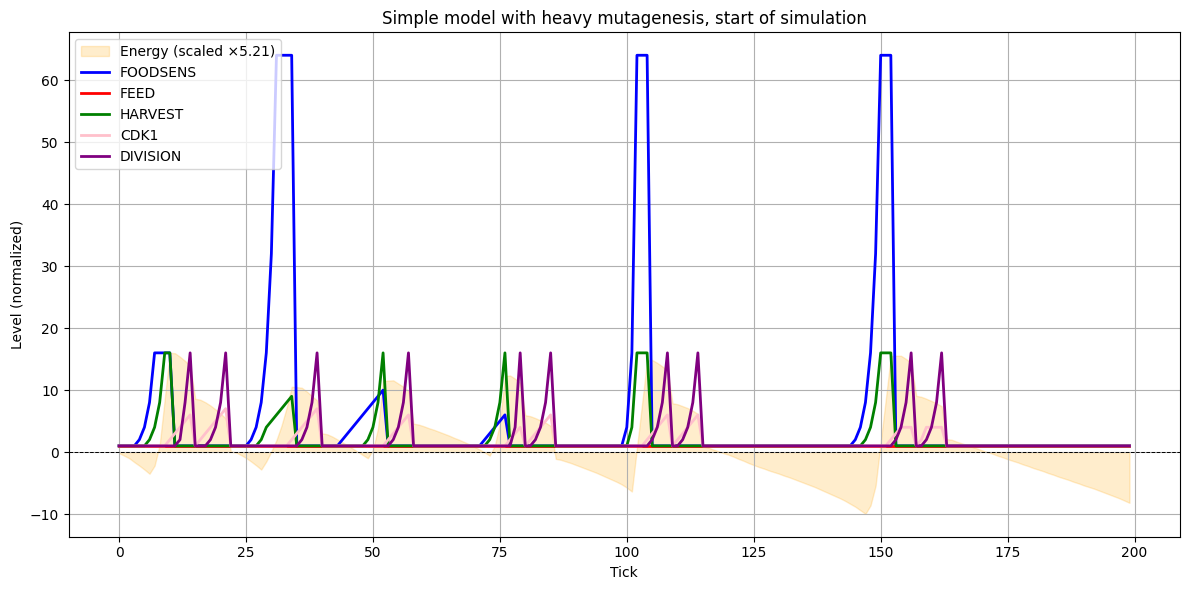

In [6]:
plot_gene_dynamics(df.iloc[:200, :], title="Simple model with heavy mutagenesis, start of simulation",
                   genes={"FOODSENS": "blue", 
                          "FEED": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

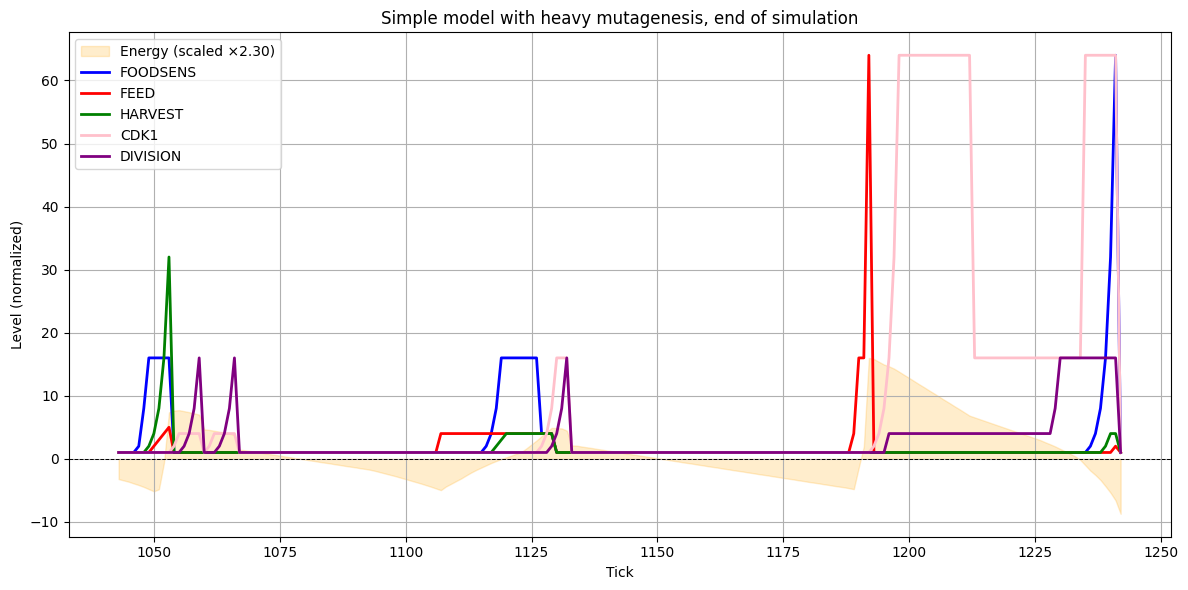

In [7]:
plot_gene_dynamics(df.iloc[-200:, :], title="Simple model with heavy mutagenesis, end of simulation",
                   genes={"FOODSENS": "blue", 
                          "FEED": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

In [8]:
# Model with average mutagenesis
df, all_genes = run_simulation(
    ticks=3000,
    initial_food=1.0,
    initial_energy=0,
    energy_cost=0.002,
    mutation_chance=0.01,
    cellular_products={
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.0))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "MUTSENS":    (2, "qual", "st", "av", ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 1)),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", ["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 2", "Energy <= -2.9", "DIVISION == 'active'"], ("energy", 0.1)),
        "FEED":   (2,  "quan", "av", "av", ["Energy <= -2"], ["Energy >= 2", "DIVISION == 'active'"], ("energy", 0.1)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (3,  "qual", "av", "wk", ["Energy >= 1"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (12, "qual", "av", "av", ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

,Food,Energotoxin,Energy,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2,-0.03,False,False,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0
1,1.0,-2,-0.11,False,False,16.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,1
2,1.0,-2,-0.19,False,False,16.0,1.0,4.0,1.0,1.0,2.0,1.0,16.0,1.0,2
3,1.0,-2,-0.31,True,False,16.0,1.0,16.0,1.0,1.0,4.0,1.0,16.0,1.0,3
4,1.0,-2,-0.43,True,False,16.0,4.0,16.0,1.0,1.0,4.0,1.0,16.0,1.0,4
5,1.0,-2,-0.57,True,False,16.0,16.0,16.0,2.0,1.0,4.0,1.0,16.0,1.0,5
6,1.0,-2,-0.32,True,False,16.0,16.0,16.0,4.0,1.0,4.0,1.0,16.0,1.0,6
7,1.0,-2,0.32,True,False,16.0,16.0,16.0,8.0,1.0,4.0,1.0,16.0,1.0,7
8,1.0,-2,1.74,True,False,16.0,16.0,16.0,16.0,1.0,4.0,1.0,16.0,1.0,8
9,1.0,-2,3.17,True,False,16.0,16.0,16.0,16.0,1.0,1.0,2.0,16.0,1.0,9


In [9]:
df.tail(5)

,Food,Energotoxin,Energy,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
2995,1.0,-2,0.17,False,False,46.0,4.0,4.0,1.0,4.0,16.0,1.0,16.0,1.0,2995
2996,1.0,-2,0.38,False,False,47.0,4.0,4.0,1.0,4.0,16.0,1.0,16.0,1.0,2996
2997,1.0,-2,0.59,False,False,48.0,4.0,4.0,1.0,4.0,16.0,1.0,16.0,1.0,2997
2998,1.0,-2,0.83,False,False,49.0,4.0,4.0,1.0,4.0,1.0,1.0,16.0,1.0,2998
2999,1.0,-2,1.06,False,False,50.0,4.0,4.0,1.0,4.0,1.0,1.0,16.0,1.0,2999


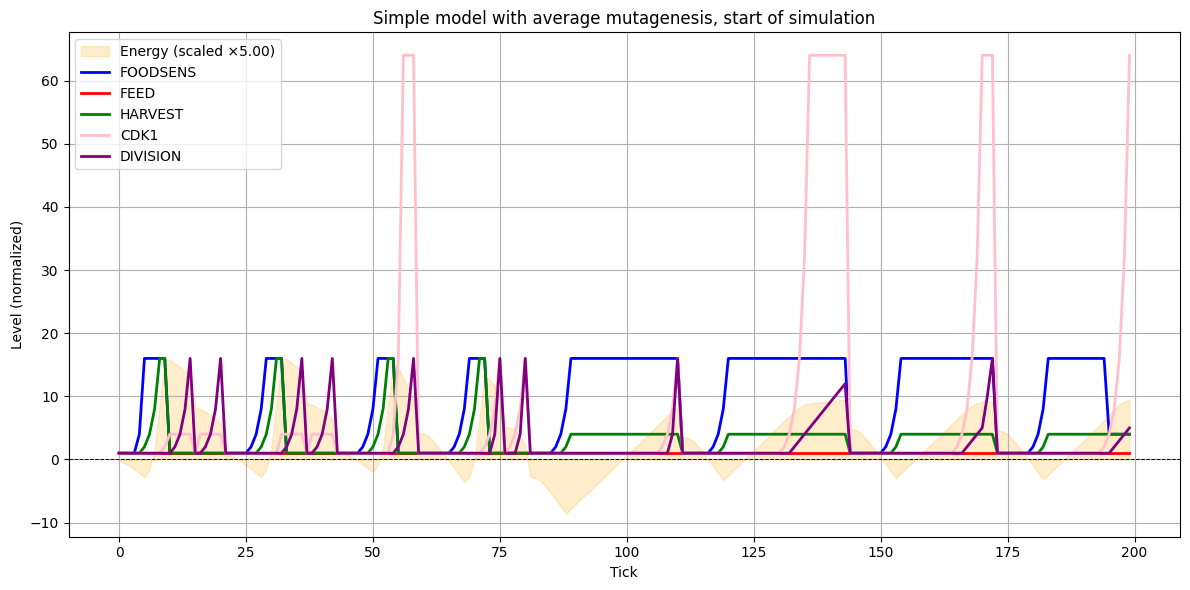

In [10]:
plot_gene_dynamics(df.iloc[:200, :], title="Simple model with average mutagenesis, start of simulation",
                   genes={"FOODSENS": "blue", 
                          "FEED": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

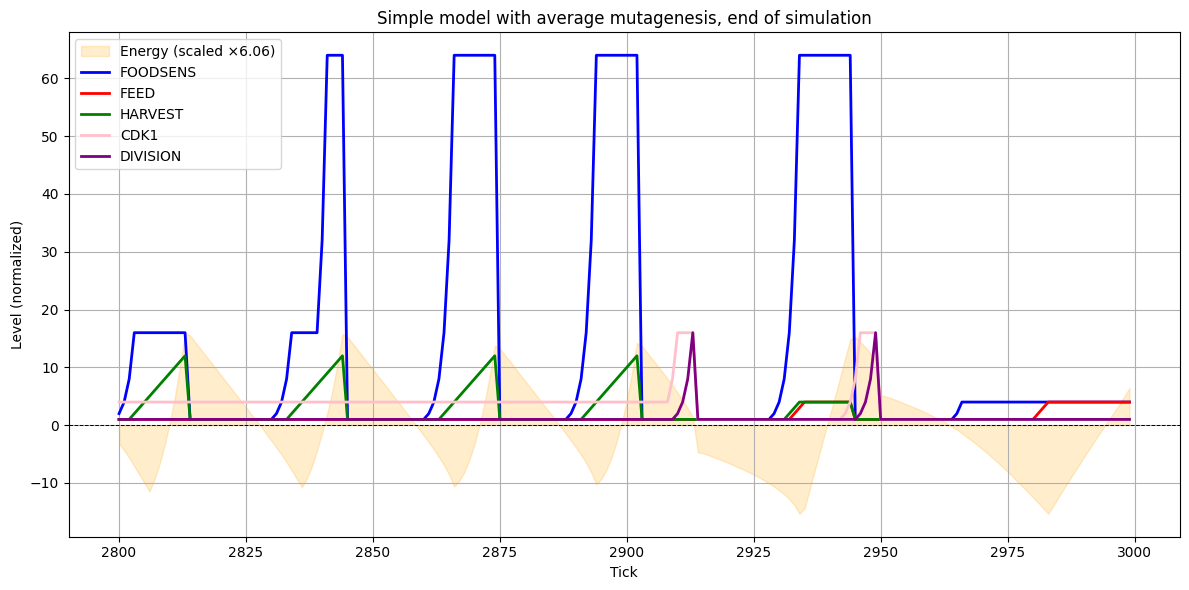

In [11]:
plot_gene_dynamics(df.iloc[-200:, :], title="Simple model with average mutagenesis, end of simulation",
                   genes={"FOODSENS": "blue", 
                          "FEED": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

In [12]:
# Bigger model with toxins, waste and low mutagenesis, but without sensor of mutations
df, all_genes = run_simulation(
    ticks=3000,
    initial_food=1.0,
    initial_energy=0,
    energy_cost=0.002,
    mutation_chance=0.001,
    cellular_products={
        "Wastetoxin": ("energy",  0.1),   # 0.1 * energy, spent for TPM
        "CytokineX":  ("TPMsum",  0.001),  # 0.05 * sum of cell's TPM
        "FooMol":     ("FOODSENS", 0.001),  # 0.2 * TPM of FOODSENS gene (only when FOODSENS active)
        "CellProduct":("CELLPROD", 0.03)
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.2)), 
        "RNAtoxin":    (-2, ("TPM", 0.1)),
        "Wastetoxin": (-3, ("common", 0.001)),
        "CytokineX":     (-3, ("energy",  0.0001)),
        "CellProduct":(-3, ("energy", 0.003))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "TOXSENS":  (2,  "qual", "wk", "wk", ["DIVISION == 'inactive'"], ["Toxin < -2.9", "DIVISION == 'active'"], ("toxsens", 0.01)),
        "TOXNONSENS":  (2,  "qual", "wk", "av", ["Energy <= -1"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("toxsens", 0.1)),
        # "MUTSENS":    (2, "qual", "st", "av", ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 0.1)),
        "STRESSRESP": (5,  "qual", "wk", "av", ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= -1", "CDK1 == 'active'", "DIVISION == 'active'"], ("energy", 0.002)),
        "FUNAKTIV":   (4,  "qual", "av", "av", ["Energy >= 0"], ["Energy < 0", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", ["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 1", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.01)),
        "FEED":    (2,  "quan", "st", "st", ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.005)),
        "AUTOPHAGY":  (2,  "quan", "av", "av", ["STRESSRESP == 'active'"], ["Energy >= -1", "DIVISION == 'active'"], ("process", 0.0005)),
        "PROTREP":    (4,  "quan", "st", "av", ["AUTOPHAGY == 'active'", "Energy <= -1.5"], ["Energy >= 1", "DIVISION == 'active'"], ("process", 0.001)),
        "DETOX":   (2,  "quan", "av", "av", ["Toxin_detected == True"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("detox", 0.01)),
        "DETOXX":   (2,  "quan", "st", "st", ["Toxin_detected == True", "Toxin >= -1"], ["Toxin <= -2", "CDK1 == 'active'", "DIVISION == 'active'"], ("detox", 1)),
        "CELLPROD": (2,  "quan", "st", "st", ["KINFUNK == 'active'"], ["Toxin > 1.5", "STRESSRESP == 'active'", "Energy <= -0.5", "DIVISION == 'active'"], ("energy", 0.005)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
        "KINTOX":    (3, "qual", "av", "wk", ["Toxin_detected == True"], ["Toxin_detected == False", "DIVISION == 'active'"], False),
        "KINSTRESS": (3, "qual", "av", "wk", ["STRESSRESP == 'active'"], ["Energy > 0", "DIVISION == 'active'"], False),
        "KINFUNK": (3, "qual", "av", "wk", ["FUNAKTIV == 'active'"], ["KINFUNK == 'active'", "STRESSRESP == 'active'", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (2,  "qual", "wk", "wk", ["Energy >= 1.25"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (6, "qual", "av", "av", ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

Cell died at tick 1410, energy=-3.01


,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,mut_detected,tox_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2.996,-2.980,-3.000,-3.0,-2.0,-2.0,-0.08,False,False,...,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,3.945666,1.0,0
1,1.0,-2.991,-2.953,-3.000,-3.0,-2.0,-2.0,-0.21,False,False,...,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,15.568275,1.0,1
2,1.0,-2.980,-2.902,-3.000,-3.0,-2.0,-2.0,-0.34,False,False,...,1.0,1.0,1.972831,1.000000,1.0,1.0,1.0,15.782651,1.0,2
3,1.0,-2.970,-2.849,-3.000,-3.0,-2.0,-2.0,-0.48,False,False,...,1.0,1.0,3.892062,1.000000,1.0,1.0,1.0,15.782642,1.0,3
4,1.0,-2.959,-2.793,-3.000,-3.0,-2.0,-2.0,-0.63,False,False,...,1.0,1.0,3.945658,1.000000,1.0,1.0,1.0,15.782633,1.0,4
5,1.0,-2.947,-2.734,-3.000,-3.0,-2.0,-2.0,-0.72,False,False,...,1.0,1.0,3.945656,1.000000,1.0,1.0,1.0,15.782623,1.0,5
6,1.0,-2.932,-2.661,-3.000,-3.0,-2.0,-2.0,-0.69,False,False,...,1.0,1.0,3.945653,1.000000,1.0,1.0,1.0,15.782611,1.0,6
7,1.0,-2.908,-2.538,-2.992,-3.0,-2.0,-2.0,-0.67,False,False,...,1.0,1.0,3.945647,1.000000,1.0,1.0,1.0,15.782590,1.0,7
8,1.0,-2.881,-2.406,-2.977,-3.0,-2.0,-2.0,-0.65,False,False,...,1.0,1.0,3.945642,1.000000,1.0,1.0,1.0,15.782566,1.0,8
9,1.0,-2.854,-2.270,-2.961,-3.0,-2.0,-2.0,-0.56,False,False,...,1.0,1.0,3.945635,1.000000,1.0,1.0,1.0,15.782542,1.0,9


In [13]:
df.tail(5)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,mut_detected,tox_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
1406,1.0,-2.936,-1.337,18.438,-3.0,-3.0,-3.0,-2.91,False,True,...,63.677965,1.0,3.979873,3.979873,63.677965,1.0,1.0,15.919491,1.0,1406
1407,1.0,-2.936,-2.010,18.454,-3.0,-3.0,-3.0,-2.92,False,True,...,1.000000,1.0,3.979873,1.000000,63.677965,1.0,1.0,15.919491,1.0,1407
1408,1.0,-2.900,-1.770,18.470,-3.0,-3.0,-3.0,-2.93,False,False,...,1.000000,1.0,3.979865,1.989933,63.677842,1.0,1.0,15.919460,1.0,1408
1409,1.0,-2.849,-1.513,18.486,-3.0,-3.0,-3.0,-2.96,False,True,...,1.000000,1.0,3.979854,3.959820,63.677656,1.0,1.0,15.919414,1.0,1409
1410,1.0,-2.796,-1.251,18.502,-3.0,-3.0,-3.0,-3.01,False,True,...,1.000000,1.0,3.979841,3.979841,63.677457,1.0,1.0,15.919364,1.0,1410


In [14]:
df.mut_detected.value_counts()

mut_detected
False    1411
Name: count, dtype: int64

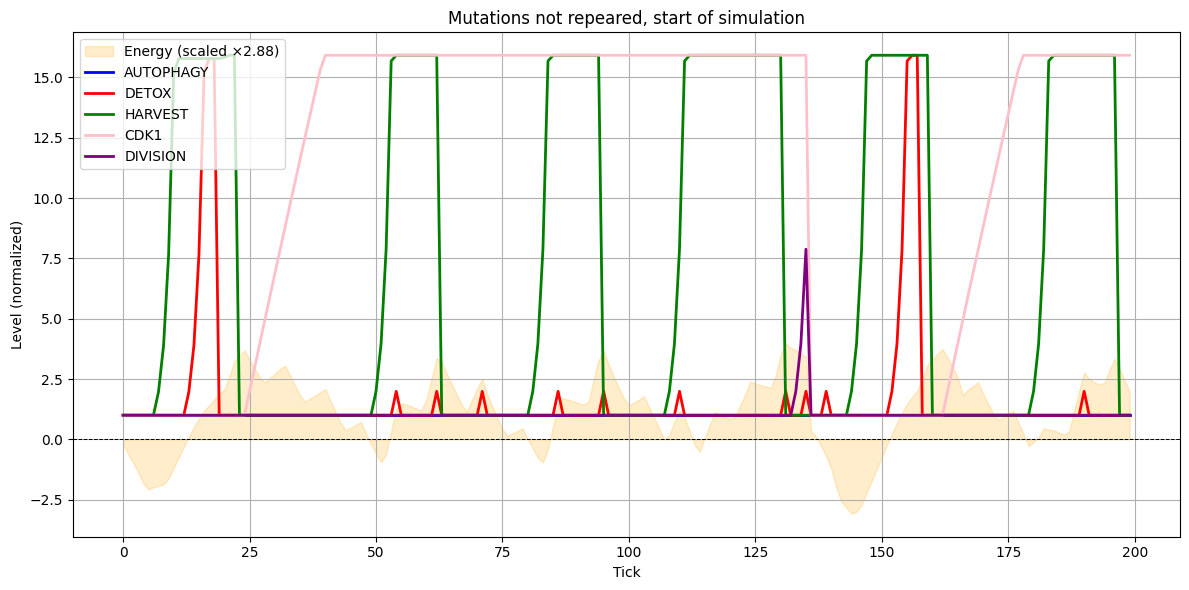

In [15]:
plot_gene_dynamics(df.iloc[:200, :], title="Mutations not repeared, start of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

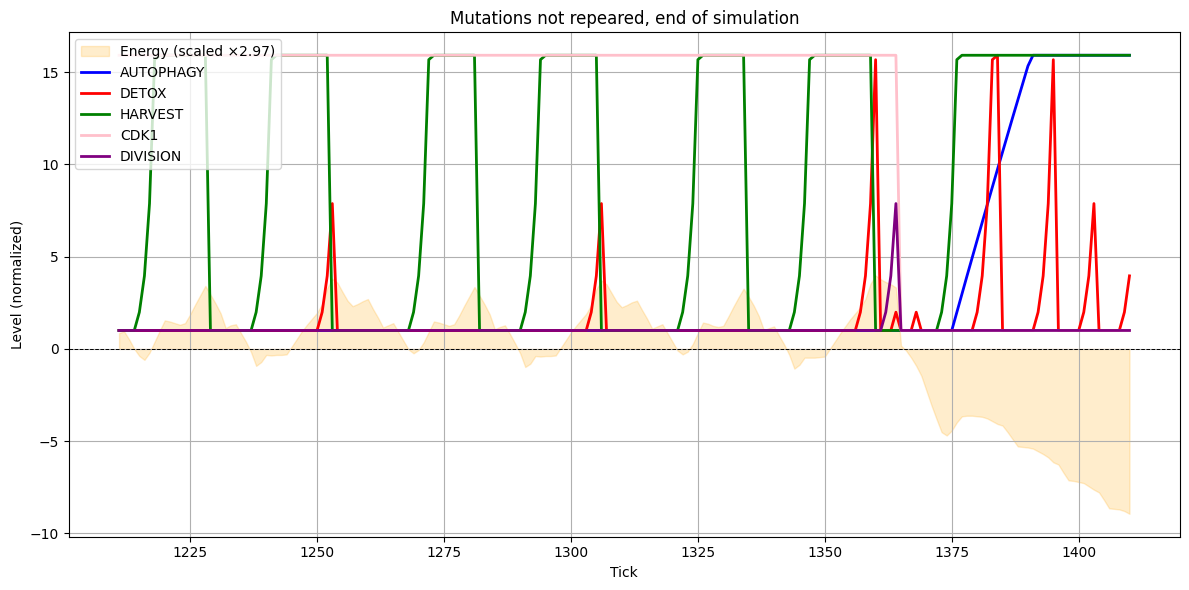

In [16]:
plot_gene_dynamics(df.iloc[-200:, :], title="Mutations not repeared, end of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

In [17]:
# Bigger model with toxins, waste and low mutagenesis, but with normal sensor of mutations
df, all_genes = run_simulation(
    ticks=3000,
    initial_food=1.0,
    initial_energy=0,
    energy_cost=0.002,
    mutation_chance=0.001,
    cellular_products={
        "Wastetoxin": ("energy",  0.1),   # 0.1 * energy, spent for TPM
        "CytokineX":  ("TPMsum",  0.001),  # 0.05 * sum of cell's TPM
        "FooMol":     ("FOODSENS", 0.001),  # 0.2 * TPM of FOODSENS gene (only when FOODSENS active)
        "CellProduct":("CELLPROD", 0.03)
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.2)), 
        "RNAtoxin":    (-2, ("TPM", 0.1)),
        "Wastetoxin": (-3, ("common", 0.001)),
        "CytokineX":     (-3, ("energy",  0.0001)),
        "CellProduct":(-3, ("energy", 0.003))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "TOXSENS":  (2,  "qual", "wk", "wk", ["DIVISION == 'inactive'"], ["Toxin < -2.9", "DIVISION == 'active'"], ("toxsens", 0.01)),
        "TOXNONSENS":  (2,  "qual", "wk", "av", ["Energy <= -1"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("toxsens", 0.1)),
        "MUTSENS":    (2, "qual", "st", "av", ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 0.1)),
        "STRESSRESP": (5,  "qual", "wk", "av", ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= -1", "CDK1 == 'active'", "DIVISION == 'active'"], ("energy", 0.002)),
        "FUNAKTIV":   (4,  "qual", "av", "av", ["Energy >= 0"], ["Energy < 0", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", ["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 1", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.01)),
        "FEED":    (2,  "quan", "st", "st", ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.005)),
        "AUTOPHAGY":  (2,  "quan", "av", "av", ["STRESSRESP == 'active'"], ["Energy >= -1", "DIVISION == 'active'"], ("process", 0.0005)),
        "PROTREP":    (4,  "quan", "st", "av", ["AUTOPHAGY == 'active'", "Energy <= -1.5"], ["Energy >= 1", "DIVISION == 'active'"], ("process", 0.001)),
        "DETOX":   (2,  "quan", "av", "av", ["Toxin_detected == True"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("detox", 0.01)),
        "DETOXX":   (2,  "quan", "st", "st", ["Toxin_detected == True", "Toxin >= -1"], ["Toxin <= -2", "CDK1 == 'active'", "DIVISION == 'active'"], ("detox", 1)),
        "CELLPROD": (2,  "quan", "st", "st", ["KINFUNK == 'active'"], ["Toxin > 1.5", "STRESSRESP == 'active'", "Energy <= -0.5", "DIVISION == 'active'"], ("energy", 0.005)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
        "KINTOX":    (3, "qual", "av", "wk", ["Toxin_detected == True"], ["Toxin_detected == False", "DIVISION == 'active'"], False),
        "KINSTRESS": (3, "qual", "av", "wk", ["STRESSRESP == 'active'"], ["Energy > 0", "DIVISION == 'active'"], False),
        "KINFUNK": (3, "qual", "av", "wk", ["FUNAKTIV == 'active'"], ["KINFUNK == 'active'", "STRESSRESP == 'active'", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (2,  "qual", "wk", "wk", ["Energy >= 1.25"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (6, "qual", "av", "av", ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,mut_detected,tox_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2.996,-2.979,-3.000,-3.0,-2.0,-2.0,-0.08,False,False,...,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,3.945666,1.0,0
1,1.0,-2.990,-2.951,-3.000,-3.0,-2.0,-2.0,-0.21,False,False,...,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,15.568275,1.0,1
2,1.0,-2.980,-2.899,-3.000,-3.0,-2.0,-2.0,-0.36,False,False,...,1.0,1.0,1.972831,1.000000,1.0,1.0,1.0,15.782651,1.0,2
3,1.0,-2.968,-2.842,-3.000,-3.0,-2.0,-2.0,-0.53,False,False,...,1.0,1.0,3.892061,1.000000,1.0,1.0,1.0,15.782641,1.0,3
4,1.0,-2.954,-2.771,-3.000,-3.0,-2.0,-2.0,-0.70,False,False,...,1.0,1.0,3.945657,1.000000,1.0,1.0,1.0,15.782630,1.0,4
5,1.0,-2.939,-2.696,-3.000,-3.0,-2.0,-2.0,-0.83,False,False,...,1.0,1.0,3.945654,1.000000,1.0,1.0,1.0,15.782617,1.0,5
6,1.0,-2.921,-2.607,-3.000,-3.0,-2.0,-2.0,-0.83,False,False,...,1.0,1.0,3.945650,1.000000,1.0,1.0,1.0,15.782602,1.0,6
7,1.0,-2.894,-2.469,-2.992,-3.0,-2.0,-2.0,-0.84,False,False,...,1.0,1.0,3.945644,1.000000,1.0,1.0,1.0,15.782578,1.0,7
8,1.0,-2.864,-2.320,-2.977,-3.0,-2.0,-2.0,-0.85,False,False,...,1.0,1.0,3.945638,1.000000,1.0,1.0,1.0,15.782551,1.0,8
9,1.0,-2.834,-2.169,-2.961,-3.0,-2.0,-2.0,-0.79,False,False,...,1.0,1.0,3.945631,1.000000,1.0,1.0,1.0,15.782523,1.0,9


In [18]:
df.tail(5)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,mut_detected,tox_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
2995,1.0,-2.591,-0.877,41.699,-2.444,-3.0,-3.0,-0.12,True,True,...,1.989893,63.676565,3.979785,3.979785,1.0,1.0,1.0,15.919141,1.0,2995
2996,1.0,-2.544,-0.633,41.715,-2.447,-3.0,-3.0,-0.15,True,True,...,3.959659,63.676336,3.979771,3.979771,1.0,1.0,1.0,15.919084,1.0,2996
2997,1.0,-2.497,-0.388,41.731,-2.449,-3.0,-3.0,-0.16,True,True,...,7.879237,63.676094,3.979756,3.979756,1.0,1.0,1.0,15.919023,1.0,2997
2998,1.0,-2.573,-0.275,41.747,-2.572,-3.0,-3.0,-0.18,True,True,...,15.678815,63.676479,3.979780,3.979780,1.0,1.0,1.0,15.919120,1.0,2998
2999,1.0,-2.769,-0.275,41.763,-2.817,-3.0,-3.0,-0.23,True,True,...,31.199543,63.677348,3.979834,3.979834,1.0,1.0,1.0,15.919337,1.0,2999


In [19]:
df.mut_detected.value_counts()

mut_detected
True     2079
False     921
Name: count, dtype: int64

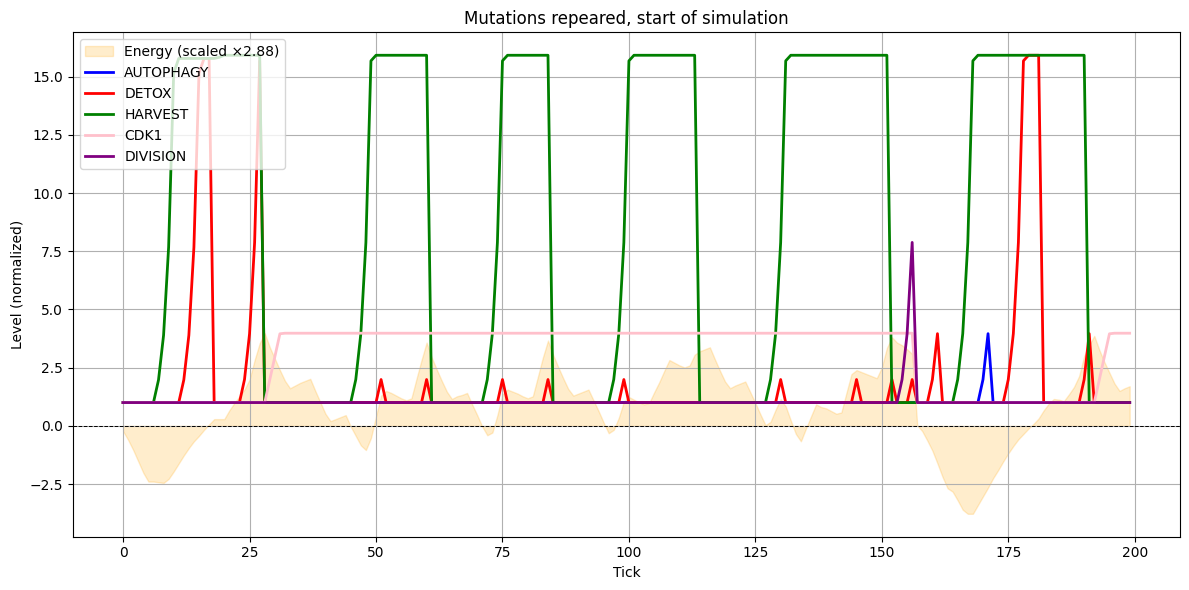

In [20]:
plot_gene_dynamics(df.iloc[:200, :], title="Mutations repeared, start of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

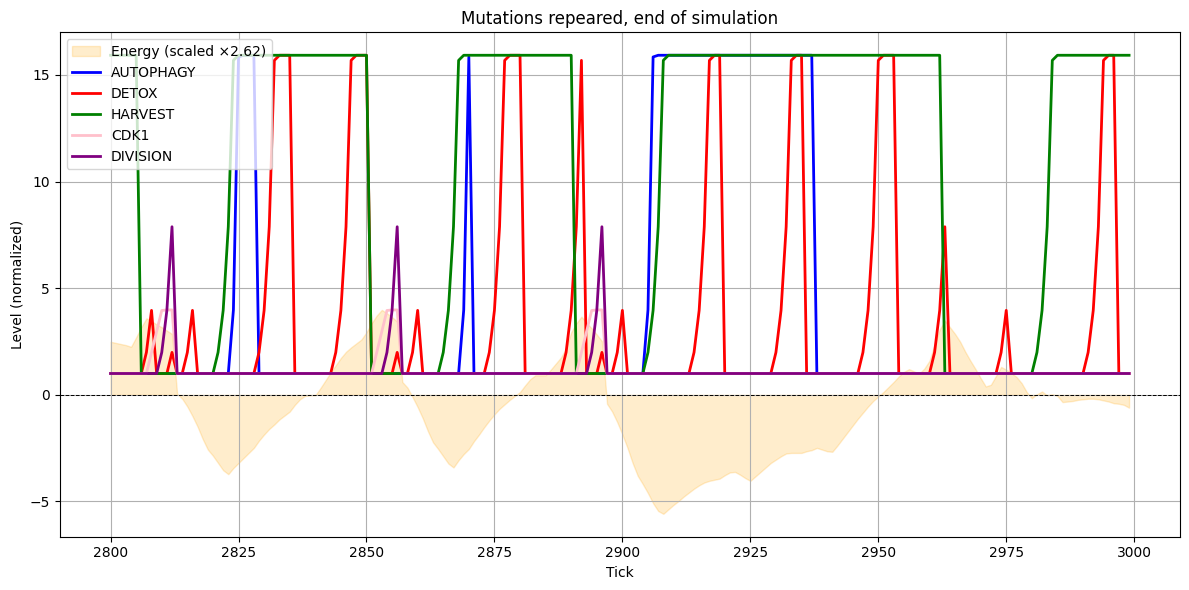

In [21]:
plot_gene_dynamics(df.iloc[-200:, :], title="Mutations repeared, end of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})